In [2]:
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 4.4 MB/s eta 0:00:00a 0:00:01


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms 
import torchvision.utils as vutils

from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
from IPython.display import display, clear_output



from PIL import Image
import numpy as np
import errno
import os
import pickle
import time
from glob import glob



import matplotlib.pyplot as plt



In [4]:
condition_dim = 256
gf_dim = 128
z_dim = 100
df_dim = 64
batch_size = 10
g_lr = 0.00022
d_lr = 0.0002
kl_coeff = 2.0
snapshot_interval = 10
model_dir = "model_weights"
image_dir = "output_images"
lr_decay_step = 20
max_epoch = 100

In [5]:
os.makedirs(model_dir, exist_ok = True)
os.makedirs(image_dir, exist_ok = True)

In [6]:
import os
import numpy as np
import pandas as pd
import cv2
from sentence_transformers import SentenceTransformer
import torch
import torch.nn as nn
import os
import pickle
import random
import time
import PIL
from PIL import Image
import matplotlib.pyplot as plt

2024-06-20 17:45:19.000945: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 17:45:19.001062: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 17:45:19.140968: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
images=[]
name=[]
for folder, subfolders , filenames in os.walk('/kaggle/input/pokemonclassification'):
    for folders in subfolders:
        path=os.path.join(folder,folders)
        imgpaths=os.listdir(path)
        for k in imgpaths:
            if os.path.join(path,k).lower().endswith(".png") or os.path.join(path,k).lower().endswith(".jpg") or os.path.join(path,k).lower().endswith(".jpeg"):
                img=cv2.imread(os.path.join(path,k))
                img=cv2.resize(img,(256,256))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                images.append(img)
                name.append(folders.lower())
print(len(images),len(name))

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


6820 6820


In [8]:
data = {'Name': name, 'Image': images}
images_df = pd.DataFrame(data)
print(images_df.head())

     Name                                              Image
0  golbat  [[[20, 31, 49], [20, 31, 49], [20, 31, 49], [2...
1  golbat  [[[8, 94, 213], [8, 93, 212], [7, 94, 210], [6...
2  golbat  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
3  golbat  [[[0, 0, 0], [0, 0, 0], [1, 0, 0], [0, 0, 1], ...
4  golbat  [[[255, 255, 255], [255, 255, 255], [255, 255,...


In [9]:
bert_model = SentenceTransformer('bert-base-nli-mean-tokens')

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [10]:
descriptions_df = pd.read_csv('/kaggle/input/pokemon-physical-descriptions/pokemon_descriptions.csv')
descriptions_df['Name'] = descriptions_df['Name'].str.lower()
embeddings=bert_model.encode(descriptions_df['Description'])
em_list = [np.array(sublist) for sublist in embeddings]
descriptions_df['embedding_bert']=em_list

Batches:   0%|          | 0/26 [00:00<?, ?it/s]

In [11]:
print("Number of rows in the DataFrame:", images_df.shape[0])

Number of rows in the DataFrame: 6820


In [12]:
merged_df = pd.merge(images_df, descriptions_df, on='Name')
merged_df = merged_df.sample(frac=1).reset_index(drop=True)

In [13]:
print(merged_df.tail())
print("Number of columns in the DataFrame:", merged_df.shape[1])
print("Number of rows in the DataFrame:", merged_df.shape[0])
print("Number of unique Pokemons:", merged_df['Name'].nunique())

            Name                                              Image  \
6681  victreebel  [[[196, 174, 167], [196, 176, 167], [197, 177,...   
6682    nidoking  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
6683   sandslash  [[[224, 184, 135], [224, 184, 135], [224, 184,...   
6684      meowth  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
6685     voltorb  [[[255, 255, 255], [255, 255, 255], [255, 255,...   

                                            Description  \
6681  Victreebel is a pitcher plant Pokémon with a b...   
6682  Nidoking is a large, bipedal, purple mammalian...   
6683  Sandslash is a bipedal, ground-dwelling pholid...   
6684  Meowth is a small, feline Pokémon with cream-c...   
6685  Voltorb is a spherical Pokémon that resembles ...   

                                         embedding_bert  
6681  [-0.8230126, 0.5902946, -0.5260416, -0.0869294...  
6682  [-0.6211894, 0.9949976, -1.4511299, -0.0930099...  
6683  [-0.8738953, 0.12120329, -1.3028083, 0

In [14]:
xs1=merged_df['Image'].tolist()
for i in range(len(xs1)):
    xs1[i] = Image.fromarray(np.uint8(xs1[i])).convert('RGB')
embed=merged_df['embedding_bert'].tolist()

In [15]:

# xs=torch.from_numpy(xs1)
embed=np.array(embed)


In [16]:
# print(xs.shape,emds.shape)

In [17]:
class StackGANDataset(torch.utils.data.Dataset):
    def __init__(self, images, embeddings, transform = None):
        super().__init__()
        
        self.transform = transform
        
        self.images = images
        self.embeddings_data = embeddings
    
    def __getitem__(self, idx):
        image = self.images[idx]        
        embedding = self.embeddings_data[idx]
        
        if self.transform is not None:
            image = self.transform(image)
        # embedding = torch.tensor(embedding, dtype = torch.float32)       
        return image , embedding
    def __len__(self):
        return len(self.images)
    
image_transform = transforms.Compose([
transforms.Resize((64, 64)),
transforms.RandomHorizontalFlip(),
transforms.ToTensor(),
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
ds = StackGANDataset(xs1,embed, transform=image_transform)        
ds.__getitem__(0)

(tensor([[[-0.2784, -0.2157,  0.4353,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.0588, -0.0510, -0.2706,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.6078,  0.7804,  0.4980,  ...,  1.0000,  1.0000,  1.0000],
          ...,
          [ 1.0000,  1.0000,  1.0000,  ...,  0.9686,  0.9529,  0.8431],
          [ 1.0000,  1.0000,  1.0000,  ...,  0.8039,  0.9765,  0.9843],
          [ 1.0000,  1.0000,  1.0000,  ...,  0.6314,  0.9686,  0.9765]],
 
         [[-0.2784, -0.2157,  0.4353,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.0588, -0.0510, -0.2706,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.6078,  0.7804,  0.4980,  ...,  1.0000,  1.0000,  1.0000],
          ...,
          [ 1.0000,  1.0000,  1.0000,  ...,  0.6314,  0.6157,  0.5137],
          [ 1.0000,  1.0000,  1.0000,  ...,  0.4824,  0.6235,  0.6314],
          [ 1.0000,  1.0000,  1.0000,  ...,  0.3490,  0.6314,  0.6392]],
 
         [[-0.2784, -0.2157,  0.4353,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.0588, -0.0510,

In [18]:
def conv(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def up(in_planes, out_planes):
    block = nn.Sequential(
        nn.Upsample(scale_factor=2, mode='nearest'),
        conv(in_planes, out_planes),
        nn.BatchNorm2d(out_planes),
        nn.ReLU(True))
    return block

class residual(nn.Module):
    def __init__(self, channel_num):
        super(residual, self).__init__()
        self.block = nn.Sequential(
            conv(channel_num, channel_num),
            nn.BatchNorm2d(channel_num),
            nn.ReLU(True),
            conv(channel_num, channel_num),
            nn.BatchNorm2d(channel_num))
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.block(x)
        out += residual
        out = self.relu(out)
        return out

In [19]:
class D_GET_LOGITS(nn.Module):
    def __init__(self, ndf, nef, bcondition=True):
        super(D_GET_LOGITS, self).__init__()
        self.df_dim = ndf
        self.ef_dim = nef
        self.bcondition = bcondition
        if bcondition:
            self.outlogits = nn.Sequential(
                conv(ndf * 8 + nef, ndf * 8),
                nn.BatchNorm2d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=4),
                nn.Sigmoid())
        else:
            self.outlogits = nn.Sequential(
                nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=4),
                nn.Sigmoid())

    def forward(self, h_code, c_code=None):
        if self.bcondition and c_code is not None:
            c_code = c_code.view(-1, self.ef_dim, 1, 1)
            c_code = c_code.repeat(1, 1, 4, 4)
            # state size (ngf+egf) x 4 x 4
            h_c_code = torch.cat((h_code, c_code), 1)
        else:
            h_c_code = h_code
        output = self.outlogits(h_c_code)
        return output.view(-1)
    
    
class CA_NET(nn.Module):
    def __init__(self, condition_dim = condition_dim, device = device):
        super(CA_NET, self).__init__()
        self.device = device
        self.t_dim = 768
        self.c_dim = condition_dim
        self.fc = nn.Linear(self.t_dim, self.c_dim * 2, bias=True).to(self.device)
        self.relu = nn.ReLU().to(self.device)

    def encode(self, text_embedding):
        text_embedding = text_embedding.to(self.device)
        x = self.relu(self.fc(text_embedding))
        mu = x[:, :self.c_dim]
        logvar = x[:, self.c_dim:]
        return mu, logvar

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.FloatTensor(std.size()).normal_().to(self.device)
        return eps.mul(std).add_(mu)

    def forward(self, text_embedding):
        mu, logvar = self.encode(text_embedding)
        c_code = self.reparametrize(mu, logvar)
        return c_code, mu, logvar

In [20]:
class STAGE1_G(nn.Module):
    def __init__(self,
                 gf_dim, condition_dim, z_dim, device = device):
        
        super(STAGE1_G, self).__init__()
        self.gf_dim = gf_dim * 8
        self.ef_dim = condition_dim
        self.z_dim = z_dim
        self.define_module()

    def define_module(self):
        ninput = self.z_dim + self.ef_dim
        ngf = self.gf_dim
        # TEXT.DIMENSION -> GAN.CONDITION_DIM
        self.ca_net = CA_NET()

        # -> ngf x 4 x 4
        self.fc = nn.Sequential(
            nn.Linear(ninput, ngf * 4 * 4, bias=False),
            nn.BatchNorm1d(ngf * 4 * 4),
            nn.ReLU(True))

        # ngf x 4 x 4 -> ngf/2 x 8 x 8
        self.upsample1 = up(ngf, ngf // 2)
        # -> ngf/4 x 16 x 16
        self.upsample2 = up(ngf // 2, ngf // 4)
        # -> ngf/8 x 32 x 32
        self.upsample3 = up(ngf // 4, ngf // 8)
        # -> ngf/16 x 64 x 64
        self.upsample4 = up(ngf // 8, ngf // 16)
        # -> 3 x 64 x 64
        self.img = nn.Sequential(
            conv(ngf // 16, 3),
            nn.Tanh())

    def forward(self, text_embedding, noise):
        c_code, mu, logvar = self.ca_net(text_embedding)
        z_c_code = torch.cat((noise, c_code), 1)
        h_code = self.fc(z_c_code)

        h_code = h_code.view(-1, self.gf_dim, 4, 4)
        h_code = self.upsample1(h_code)
        h_code = self.upsample2(h_code)
        h_code = self.upsample3(h_code)
        h_code = self.upsample4(h_code)
        fake_img = self.img(h_code)
        return None, fake_img, mu, logvar

In [21]:
class STAGE1_D(nn.Module):
    def __init__(self, df_dim, condition_dim):
        super(STAGE1_D, self).__init__()
        self.df_dim = df_dim
        self.ef_dim = condition_dim
        self.define_module()

    def define_module(self):
        ndf, nef = self.df_dim, self.ef_dim
        self.encode_img = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (ndf*2) x 16 x 16
            nn.Conv2d(ndf*2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (ndf*4) x 8 x 8
            nn.Conv2d(ndf*4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            # state size (ndf * 8) x 4 x 4)
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.get_cond_logits = D_GET_LOGITS(ndf, nef)
        self.get_uncond_logits = None

    def forward(self, image):
        img_embedding = self.encode_img(image)

        return img_embedding

In [22]:
class STAGE2_G(nn.Module):
    def __init__(self, STAGE1_G,
                 gf_dim, z_dim, condition_dim, r_num = 1):
        super(STAGE2_G, self).__init__()
        self.STAGE1_G = STAGE1_G
        self.gf_dim = gf_dim
        self.ef_dim = condition_dim
        self.z_dim = z_dim
        self.r_num = r_num
        for param in self.STAGE1_G.parameters():
            param.requires_grad = False
        self.define_module()

    def _make_layer(self, block, channel_num):
        layers = []
        for i in range(self.r_num):
            layers.append(block(channel_num))
        return nn.Sequential(*layers)

    def define_module(self):
        ngf = self.gf_dim
        self.ca_net = CA_NET()
        self.encoder = nn.Sequential(
            conv(3, ngf),
            nn.ReLU(True),
            nn.Conv2d(ngf, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.Conv2d(ngf * 2, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True))
        self.hr_joint = nn.Sequential(
            conv(self.ef_dim + ngf * 4, ngf * 4),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True))
        self.residual = self._make_layer(residual, ngf * 4)
        # --> 2ngf x 32 x 32
        self.upsample1 = up(ngf * 4, ngf * 2)
        # --> ngf x 64 x 64
        self.upsample2 = up(ngf * 2, ngf)
        # --> ngf // 2 x 128 x 128
        self.upsample3 = up(ngf, ngf // 2)
        # --> ngf // 4 x 256 x 256
        self.upsample4 = up(ngf // 2, ngf // 4)
        # --> 3 x 256 x 256
        self.img = nn.Sequential(
            conv(ngf // 4, 3),
            nn.Tanh())

    def forward(self, text_embedding, noise):
        _, stage1_img, _, _ = self.STAGE1_G(text_embedding, noise)
        stage1_img = stage1_img.detach()
        encoded_img = self.encoder(stage1_img)

        c_code, mu, logvar = self.ca_net(text_embedding)
        c_code = c_code.view(-1, self.ef_dim, 1, 1)
        c_code = c_code.repeat(1, 1, 16, 16)
        i_c_code = torch.cat([encoded_img, c_code], 1)
        h_code = self.hr_joint(i_c_code)
        h_code = self.residual(h_code)

        h_code = self.upsample1(h_code)
        h_code = self.upsample2(h_code)
        h_code = self.upsample3(h_code)
        h_code = self.upsample4(h_code)

        fake_img = self.img(h_code)
        return stage1_img, fake_img, mu, logvar


In [23]:

class STAGE2_D(nn.Module):
    def __init__(self, df_dim = 256, condition_dim = condition_dim):
        super(STAGE2_D, self).__init__()
        self.df_dim = df_dim
        self.ef_dim = condition_dim
        self.define_module()

    def define_module(self):
        ndf, nef = self.df_dim, self.ef_dim
        self.encode_img = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),  # 128 * 128 * ndf
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),  # 64 * 64 * ndf * 2
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),  # 32 * 32 * ndf * 4
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),  # 16 * 16 * ndf * 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),  # 8 * 8 * ndf * 16
            nn.Conv2d(ndf * 16, ndf * 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 32),
            nn.LeakyReLU(0.2, inplace=True),  # 4 * 4 * ndf * 32
            conv(ndf * 32, ndf * 16),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),   # 4 * 4 * ndf * 16
            conv(ndf * 16, ndf * 8),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True)   # 4 * 4 * ndf * 8
        )

        self.get_cond_logits = D_GET_LOGITS(ndf, nef, bcondition=True)
        self.get_uncond_logits = D_GET_LOGITS(ndf, nef, bcondition=False)

    def forward(self, image):
        img_embedding = self.encode_img(image)

        return img_embedding
    
stage2_d = STAGE2_D().to(device)


In [24]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)
        if m.bias is not None:
            m.bias.data.fill_(0.0)

In [25]:
# model = STAGE1_G(gf_dim, condition_dim, z_dim, device)
# model.load_state_dict(torch.load('/kaggle/input/s1generator/netG_epoch_80.pth'))

# model = model.to(device) # Set model to gpu
# model.eval();

In [32]:
def load_nns_stage1(STAGE1_G = STAGE1_G, STAGE_1D = STAGE1_D,
                    gf_dim = 128, df_dim = 64,
                    condition_dim = 256, z_dim = 100, device = device):
    netG = STAGE1_G(gf_dim, condition_dim, z_dim, device).apply(weights_init)
#     netG = model
    netD = STAGE1_D(df_dim, condition_dim).apply(weights_init)
    return netG.to(device), netD.to(device)

def load_nns_stage2(STAGE1_G = STAGE1_G, STAGE2_G = STAGE2_G, STAGE2_D = STAGE2_D,
                    gf_dim = 128, condition_dim = 256, 
                    z_dim = 100, r_num = 1,df_dim = 64, device = device):
    stage1_g = STAGE1_G(gf_dim, condition_dim,
                        z_dim, device)
    netG = STAGE2_G(stage1_g, gf_dim, z_dim, condition_dim, r_num)
    netG.apply(weights_init)
    
    netD = STAGE2_D(df_dim, condition_dim) 
    netD.apply(weights_init)
    return netG.to(device), netD.to(device)

In [27]:
def KL_loss(mu, logvar):
    
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.mean(KLD_element).mul_(-0.5)
    return KLD

def compute_discriminator_loss(netD, real_imgs, fake_imgs,
                               real_labels, fake_labels,
                               conditions):
    criterion = nn.BCELoss()
    batch_size = real_imgs.size(0)
    cond = conditions.detach()
    fake = fake_imgs.detach()
    real_features = netD(real_imgs)
    fake_features = netD(fake)
    
    inputs = (real_features, cond)
    real_logits = netD.get_cond_logits(*inputs)
    errD_real = criterion(real_logits, real_labels)
    
    inputs = (real_features[:(batch_size-1)], cond[1:])
    wrong_logits = netD.get_cond_logits(*inputs)
    errD_wrong = criterion(wrong_logits, fake_labels[1:])
    
    inputs = (fake_features, cond)
    fake_logits = netD.get_cond_logits(*inputs)
    errD_fake = criterion(fake_logits, fake_labels)

    if netD.get_uncond_logits is not None:
        real_logits = netD.get_uncond_logits(real_features)
        fake_logits = netD.get_uncond_logits(fake_features)
        uncond_errD_real = criterion(real_logits, real_labels)
        uncond_errD_fake = criterion(fake_logits, fake_labels)
        
        errD = ((errD_real + uncond_errD_real) / 2. +
                (errD_fake + errD_wrong + uncond_errD_fake) / 3.)
        errD_real = (errD_real + uncond_errD_real) / 2.
        errD_fake = (errD_fake + uncond_errD_fake) / 2.
    else:
        errD = errD_real + (errD_fake + errD_wrong) * 0.5
    return errD, errD_real.item(), errD_wrong.item(), errD_fake.item()

def compute_generator_loss(netD, fake_imgs, real_labels, conditions):
    criterion = nn.BCELoss()
    cond = conditions.detach()
    fake_features = netD(fake_imgs)
    
    inputs = (fake_features, cond)
    fake_logits = netD.get_cond_logits(*inputs)
    errD_fake = criterion(fake_logits, real_labels)
    if netD.get_uncond_logits is not None:
        fake_logits = netD.get_uncond_logits(fake_features)
        uncond_errD_fake = criterion(fake_logits, real_labels)
        errD_fake += uncond_errD_fake
    return errD_fake


In [28]:
def save_img_results(data_img, fake, epoch, image_dir, vis_count):
    num = vis_count
    fake = fake[0:num]

    if data_img is not None:
        data_img = data_img[0:num]
        vutils.save_image(data_img, f'{image_dir}/real_samples.png', normalize=True)
        vutils.save_image(fake.data, f'{image_dir}/fake_samples_epoch_{epoch:03d}.png', normalize=True)
    else:
        vutils.save_image(fake.data, f'{image_dir}/lr_fake_samples_epoch_{epoch:03d}.png', normalize=True)

def save_model(netG, netD, epoch, model_dir):
    torch.save(netG.state_dict(), f'{model_dir}/netG_epoch_{epoch}.pth')
    torch.save(netD.state_dict(), f'{model_dir}/netD_epoch_last.pth')
    print('Save G/D models')

def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise


In [29]:
g_losses = list()
d_losses = list()
kl_losses = list()

In [30]:
dl = torch.utils.data.DataLoader(ds,
                                 batch_size = batch_size,
                                 shuffle = True,
                                 num_workers = 0,
                                 pin_memory = True, drop_last = True)

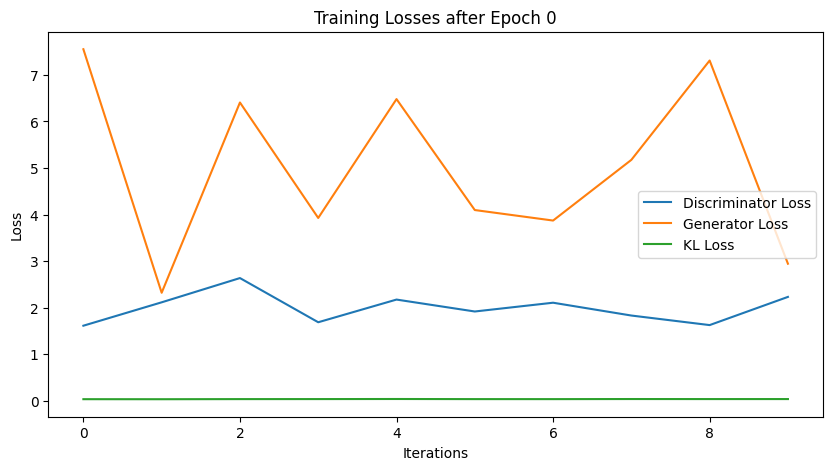

[0/100][9/668] Loss_D: 2.2321 Loss_G: 2.8685 Loss_KL: 0.0382
Loss_real: 1.8917 Loss_wrong:0.5696 Loss_fake 0.1111
Total Time: 6.31sec


KeyboardInterrupt: 

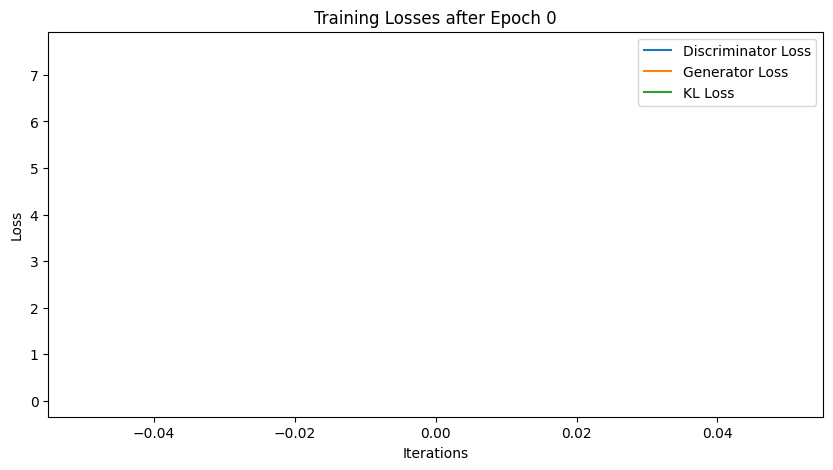

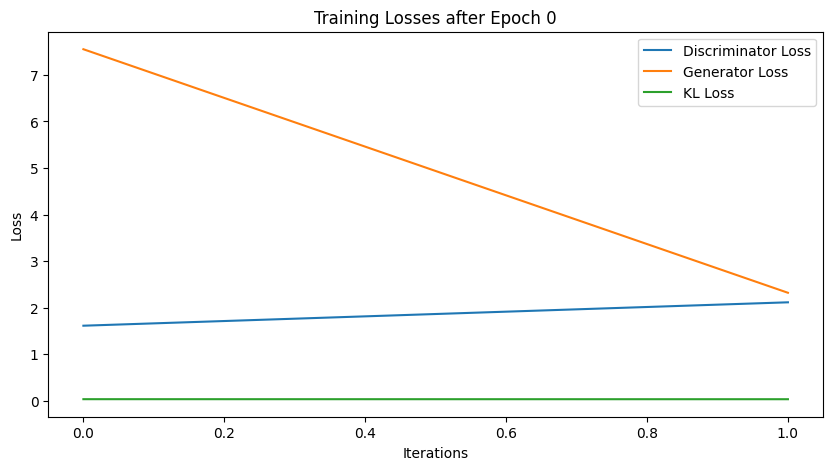

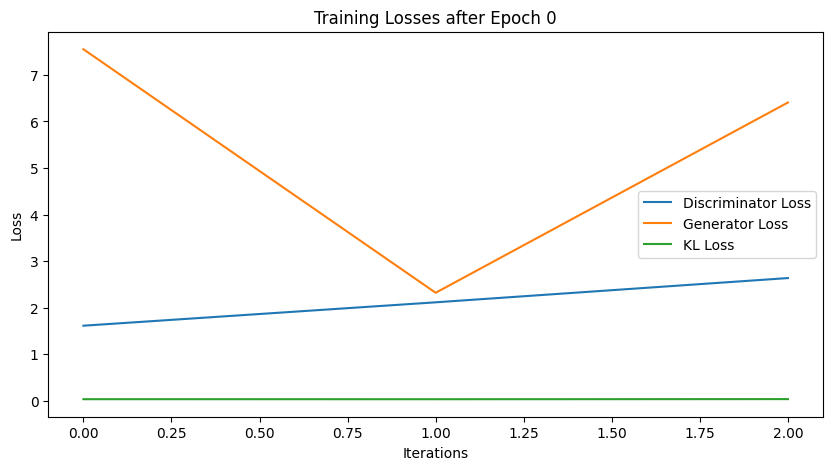

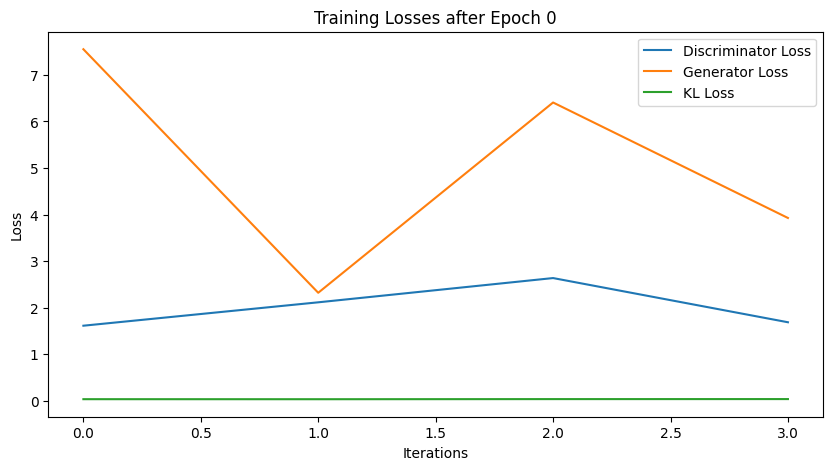

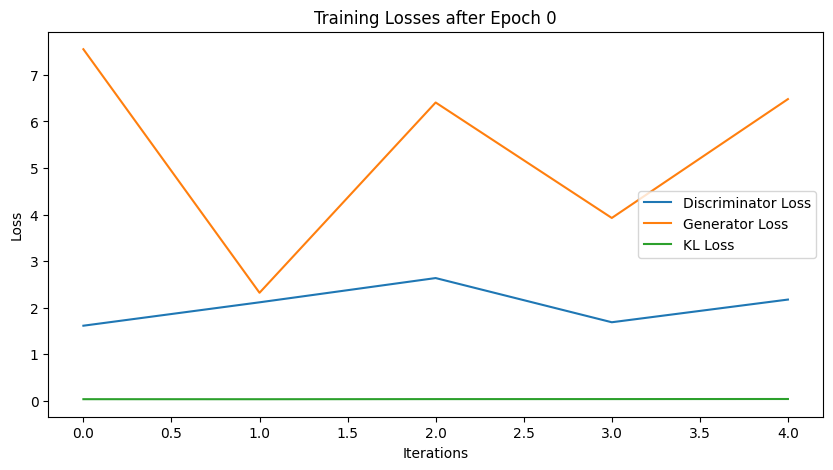

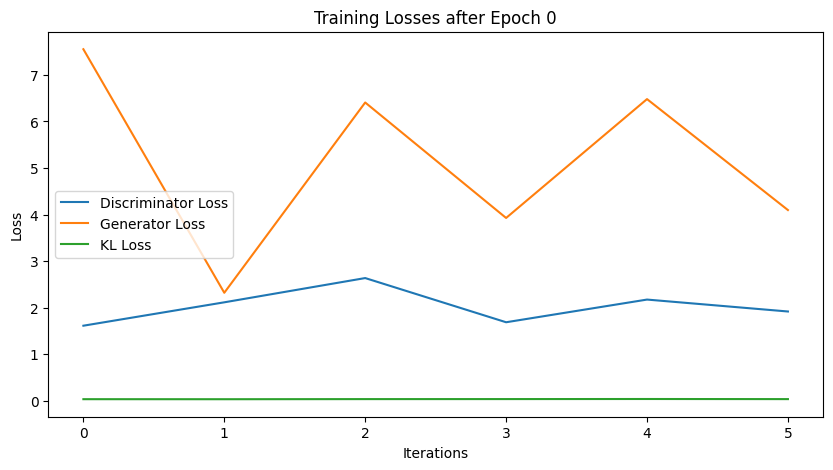

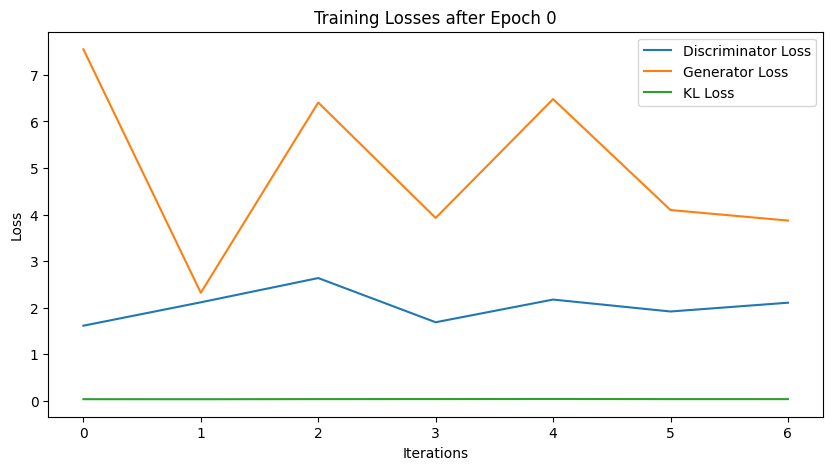

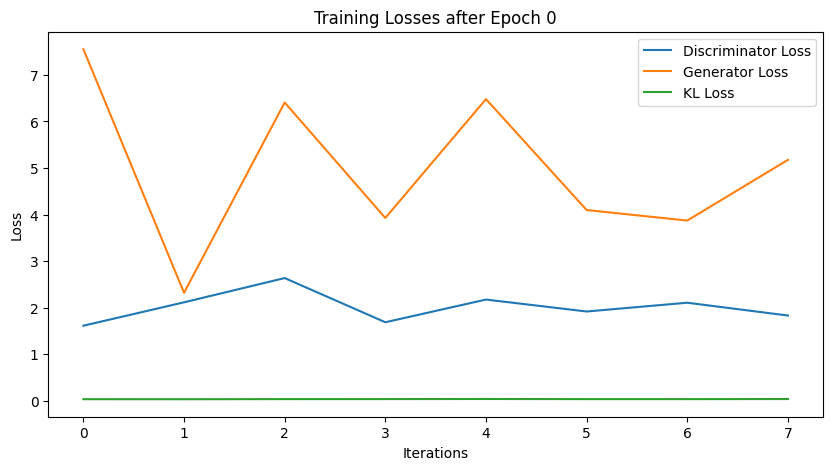

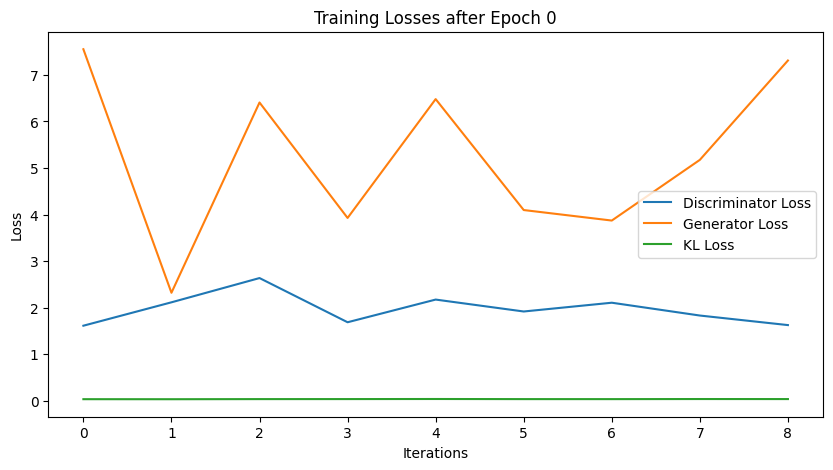

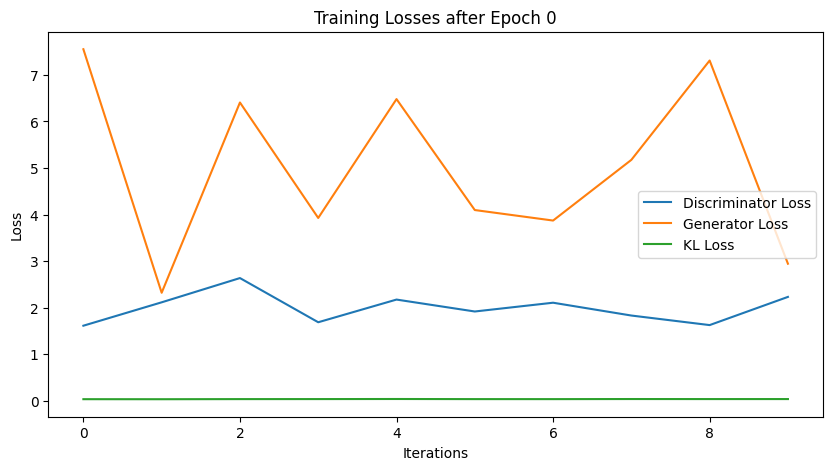

In [36]:

def train(data_loader, stage=1, STAGE1_G=STAGE1_G, STAGE1_D=STAGE1_D, STAGE2_D=STAGE2_D, STAGE2_G=STAGE2_G,
          ):
    if stage == 1:
        netG, netD = load_nns_stage1()
    else:
        netG, netD = load_nns_stage2()
    g_lr = 0.0002
    d_lr = 0.0002
    nz = z_dim
    noise = torch.randn((batch_size, nz), dtype=torch.float32).to(device)
    fixed_noise = torch.randn((batch_size, nz), dtype=torch.float32).normal_(0, 1).to(device)
    real_labels = torch.ones((batch_size,), dtype=torch.float32).to(device)
    fake_labels = torch.zeros((batch_size,), dtype=torch.float32).to(device)
    optimizer_d = torch.optim.Adam(netD.parameters(), lr=d_lr, betas=(0.5, 0.999))
    netg_para = []
    for p in netG.parameters():
        if p.requires_grad:
            netg_para.append(p)
    optimizer_g = torch.optim.Adam(netg_para, lr=g_lr, betas=(0.5, 0.999))
    count = 0
    
    d_losses = []
    g_losses = []
    kl_losses = []
    
    for epoch in range(max_epoch):
        start = time.time()
        
        if epoch % lr_decay_step == 0 and epoch > 0:
            g_lr *= 0.5
            for param_group in optimizer_g.param_groups:
                param_group["lr"] = d_lr
            d_lr *= 0.5
            for param_group in optimizer_d.param_groups:
                param_group["lr"] = d_lr
        for i, data in enumerate(data_loader, 0):
            real_img_cpu, txt_embedding = data
            real_img_cpu, txt_embedding = real_img_cpu.to(device), txt_embedding.to(device)
            noise.data.normal_(0, 1)
            if txt_embedding.size(0) != noise.size(0):
                print(f"Skipping iteration {i} due to tensor size mismatch")
                continue
            _, fake_imgs, mu, logvar = netG(txt_embedding, noise)
            netD.zero_grad()
            errd, errd_real, errd_wrong, errd_fake = compute_discriminator_loss(netD, real_img_cpu, fake_imgs, real_labels, fake_labels, mu)
            errd.backward()
            d_losses.append(errd.item())
            optimizer_d.step()
            netG.zero_grad()
            errg = compute_generator_loss(netD, fake_imgs, real_labels, mu)
            kl_loss = KL_loss(mu, logvar)
            kl_losses.append(kl_loss.item())
            errg_total = errg + kl_loss * kl_coeff
            g_losses.append(errg_total.item())
            errg_total.backward()
            optimizer_g.step()
            count += 1
            
            clear_output(wait = True)
            plt.figure(figsize=(10, 5))
            plt.title(f"Training Losses after Epoch {epoch}")
            plt.plot(d_losses, label="Discriminator Loss")
            plt.plot(g_losses, label="Generator Loss")
            plt.plot(kl_losses, label="KL Loss")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")
            plt.legend()
            display(plt.gcf())
            
            
            if i % 100 == 0:
                inputs = (txt_embedding, fixed_noise)
                lr_fake, fake, _, _ = netG(*inputs)
                save_img_results(real_img_cpu, fake, epoch, image_dir, vis_count=100)
                if lr_fake is not None:
                    save_img_results(None, lr_fake, epoch, image_dir, vis_count=100)
            end_t = time.time()
            print(f'[{epoch}/{max_epoch}][{i}/{len(data_loader)}] Loss_D: {errd.item():.4f} Loss_G: {errg.item():.4f} Loss_KL: {kl_loss.item():.4f}\nLoss_real: {errd_real:.4f} Loss_wrong:{errd_wrong:.4f} Loss_fake {errd_fake:.4f}\nTotal Time: {(end_t - start):.2f}sec')
            if epoch % snapshot_interval == 0:
                save_model(netG, netD, epoch, "model_weights")
                
    torch.save(netG.state_dict(), f'{model_dir}/netG_epoch_last.pth')
    torch.save(netD.state_dict(), f'{model_dir}/netD_epoch_last.pth')
    print('Save G/D models')

train(dl)